# Pairwise MLP with PU

Get tracksters from a certain neighbourhood.

Train a NN to decide whether two tracksters should be joined.

Neighbourhood:
- cone around the candidate trackster


## MLP

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from sklearn.preprocessing import StandardScaler
from reco.loss import FocalLoss

from reco.datasetPU import TracksterPairsPU
from reco.training import precision_recall_curve


ds_name = "CloseByGamma200PUFull"
data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# ds_name = "CloseByGamma200PUFull"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
ds = TracksterPairsPU(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=464,
    radius=10
)

ds.x.shape
ds.processed_file_names

['TracksterPairsPU_CloseByGamma200PUFull_f464_r10_s0.2.pt']

In [4]:
scaler = StandardScaler()
scaler.fit(ds.x)
ds.x = torch.tensor(scaler.transform(ds.x)).type(torch.float)

In [5]:
print(ds.x.shape)
print("Positive:", int((ds.y > 0.5).type(torch.int).sum()))
print("Negative:", int((ds.y < 0.5).type(torch.int).sum()))

torch.Size([175356, 43])
Positive: 12461
Negative: 162895


In [6]:
balance =  float(sum(ds.y) / len(ds.y))
print(f"dataset balance: {balance*100:.2f}% / {(1-balance)*100:.2f}%") 

dataset balance: 9.91% / 90.09%


In [7]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train samples: {len(train_set)}, Test samples: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=64, shuffle=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True)

Train samples: 157821, Test samples: 17535


In [8]:
def train(model, opt, loader, loss_obj):
    epoch_loss = 0
    for batch, labels in loader:
        # reset optimizer and enable training mode
        opt.zero_grad()
        model.train()

        # move data to the device
        batch = batch.to(device)
        labels = labels.to(device)
        
        # get the prediction tensor
        z = model(batch).reshape(-1)

        # compute the loss
        loss = loss_obj(z, labels)        
        epoch_loss += loss

        # back-propagate and update the weight
        loss.backward()
        opt.step()

    return float(epoch_loss)

@torch.no_grad()
def test(model, data):
    total = 0
    correct = 0
    for batch, labels in data:
        model.eval()
        batch = batch.to(device)
        labels = labels.to(device)
        z = model(batch).reshape(-1)
        prediction = (z > 0.5).type(torch.int)
        labels_acc = (labels > 0.5).type(torch.int)
        total += len(prediction) 
        correct += sum(prediction == labels_acc)
    return (correct / total)

In [9]:
model = nn.Sequential(
    nn.Linear(ds.x.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Dropout(p=0.2),
    nn.Sigmoid()
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
loss_obj = FocalLoss(alpha=1-balance, gamma=2)

epochs = 51

for epoch in range(epochs):
    loss = train(model, optimizer, train_dl, loss_obj)
    train_acc = test(model, train_dl)
    test_acc = test(model, test_dl)
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, loss: {loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

Epoch: 0, loss: 9.2417, train acc: 0.9673, test acc: 0.9669
Epoch: 5, loss: 8.3363, train acc: 0.9691, test acc: 0.9668
Epoch: 10, loss: 8.2688, train acc: 0.9689, test acc: 0.9672
Epoch: 15, loss: 8.2470, train acc: 0.9704, test acc: 0.9673
Epoch: 20, loss: 7.9844, train acc: 0.9719, test acc: 0.9668
Epoch: 25, loss: 7.9433, train acc: 0.9737, test acc: 0.9662
Epoch: 30, loss: 7.9273, train acc: 0.9746, test acc: 0.9662
Epoch: 35, loss: 7.8801, train acc: 0.9752, test acc: 0.9656
Epoch: 40, loss: 7.6852, train acc: 0.9769, test acc: 0.9646
Epoch: 45, loss: 7.6584, train acc: 0.9775, test acc: 0.9649
Epoch: 50, loss: 7.6832, train acc: 0.9778, test acc: 0.9648
Epoch: 55, loss: 7.5143, train acc: 0.9784, test acc: 0.9642
Epoch: 60, loss: 7.5544, train acc: 0.9795, test acc: 0.9644
Epoch: 65, loss: 7.4947, train acc: 0.9795, test acc: 0.9642
Epoch: 70, loss: 7.3611, train acc: 0.9801, test acc: 0.9636
Epoch: 75, loss: 7.4469, train acc: 0.9804, test acc: 0.9632
Epoch: 80, loss: 7.3386, t

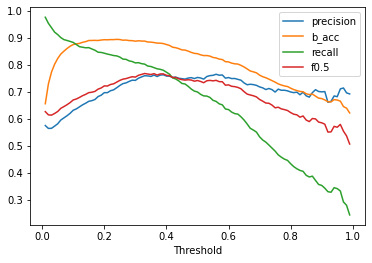

TP: 1365, TN: 15402, FP: 432, FN: 336
TH: 0.33 Acc: 0.956 BAcc: 0.888 P: 0.760 R: 0.802 F0.5: 0.768


In [10]:
precision_recall_curve(model, device, test_dl)